In [1]:
import torch
from torch.utils.data import DataLoader
from utils import *
from tqdm import tqdm
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from utils import *

#matplotlib mpatches and mcolors
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors



model_dir = 'models/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
N = 100
df_filtered = pd.read_csv("original_training_set_filtered.csv")
df_train = pd.read_csv("splits/train.csv")
df_val = pd.read_csv("splits/val.csv")
df_test = pd.read_csv("splits/test.csv")

# Preprocessing
feature_columns = [col for col in df_train.columns if col not in ["label", "exp_name"]]
scaler = StandardScaler()
scaler.fit(df_train[feature_columns])
mean = scaler.mean_
std = scaler.scale_

# Label encoding
exp_labels = df_filtered.groupby("exp_name")["label"].first()
label_encoder = LabelEncoder()
label_encoder.fit(exp_labels.values)
exp_name_to_label = exp_labels.to_dict()

# Dataset creation with overlap
train_dataset = SensorDataset(df_train, exp_name_to_label, label_encoder, mean, std, N = N)
val_dataset   = SensorDataset(df_val,   exp_name_to_label, label_encoder, mean, std, N = N)
test_dataset  = SensorDataset(df_test,  exp_name_to_label, label_encoder, mean, std, N = N)

In [3]:
def build_prediction_matrix(model_path, model_class, dataset, label_encoder, mode="score", device="cpu"):
    """
    Builds a prediction matrix from a SensorDataset object (time window version).

    Args:
        model_path: path to the Lightning .ckpt file
        model_class: class used to load the model
        dataset: a SensorDataset instance (time windows version)
        label_encoder: fitted LabelEncoder
        mode: "score" or "standing"
        device: "cpu" or "cuda"

    Returns:
        - prediction_matrix (N x M): np.array with correct-class scores or standing indicators
        - index_to_exp: dict mapping row index to exp_name
    """

    assert mode in ["score", "standing"], "Mode must be 'score' or 'standing'"

    # Load model
    model = model_class.load_from_checkpoint(model_path)
    model.to(device)
    model.eval()

    # Group samples by exp_name
    exp_dict = {}  # exp_name -> list of (windowed) feature tensors
    for i in range(len(dataset)):
        features, _, exp_name = dataset[i]
        if exp_name not in exp_dict:
            exp_dict[exp_name] = []
        exp_dict[exp_name].append(features)

    exp_names = list(exp_dict.keys())
    exp_to_idx = {exp: i for i, exp in enumerate(exp_names)}
    index_to_exp = {i: exp for exp, i in exp_to_idx.items()}

    max_len = max(len(seq) for seq in exp_dict.values())
    num_exps = len(exp_names)
    prediction_matrix = np.full((num_exps, max_len), np.nan)

    with torch.no_grad():
        for exp_name in tqdm(exp_names, desc=f"Predicting ({mode})"):
            sequence = exp_dict[exp_name]  # list of [N, 16] tensors (N = window size)
            features = torch.stack(sequence).to(device)  # shape: [seq_len, N, 16]

            logits = model(features)  # shape: [seq_len, num_classes]
            probs = torch.softmax(logits, dim=1)

            # Get correct class index
            gt_label = label_encoder.transform([dataset.exp_name_to_label[exp_name]])[0]
            row_idx = exp_to_idx[exp_name]
            seq_len = probs.shape[0]

            if mode == "score":
                correct_class_scores = probs[:, gt_label].cpu().numpy()
                prediction_matrix[row_idx, :seq_len] = correct_class_scores

            elif mode == "standing":
                topk = torch.topk(probs, k=5, dim=1).indices.cpu().numpy()
                for j in range(seq_len):
                    if gt_label == topk[j][0]:
                        prediction_matrix[row_idx, j] = 1.0
                    elif gt_label in topk[j]:
                        prediction_matrix[row_idx, j] = 0.25
                    else:
                        prediction_matrix[row_idx, j] = 0.0

    return prediction_matrix, index_to_exp



def plot_prediction_matrix(matrix, index_to_exp, df, order="length", cmap_color="Greens",
                           title="Prediction Matrix", mode="score", figsize=(15, 8)):
    """
    Plots the prediction matrix with NaNs in dark gray.

    Args:
        matrix: NxM np.array of predictions with NaNs
        index_to_exp: dict mapping row index to exp_name
        df: full dataframe with at least 'exp_name' and 'label'
        order: 'length' or 'label'
        cmap_color: base colormap name (e.g., 'Greens', 'Blues', etc.)
        title: title of the plot
        mode: 'score' or 'standing'
    """

    # Get exp_name for each row
    exp_names = [index_to_exp[i] for i in range(len(index_to_exp))]

    # Build sort key
    if order == "length":
        lengths = df.groupby("exp_name").size()
        sort_key = [lengths[exp] for exp in exp_names]
    elif order == "label":
        labels = df.groupby("exp_name")["label"].first()
        sort_key = [labels[exp] for exp in exp_names]
    else:
        raise ValueError("order must be 'length' or 'label'")

    # Sort matrix
    sorted_indices = np.argsort(sort_key)
    sorted_matrix = matrix[sorted_indices]

    plt.figure(figsize=figsize)

    if mode == "score":
        # Copy matrix and replace NaNs with a value > 1
        display_matrix = sorted_matrix.copy()
        nan_mask = np.isnan(display_matrix)
        display_matrix[nan_mask] = 1.1  # Put NaNs just above valid range

        # Create colormap from 0 to 1, set over-range color to black
        cmap = plt.get_cmap(cmap_color)
        norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
        custom_cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, 256)))
        custom_cmap.set_over(color='black')  # for NaNs

        im = plt.imshow(display_matrix, aspect="auto", cmap=custom_cmap,
                        norm=norm, interpolation="nearest")

        # Add colorbar: only from 0 to 1
        cbar = plt.colorbar(im, extend='max')
        cbar.set_label("Predicted Score")

        # Add custom legend for NaN
        import matplotlib.patches as mpatches
        nan_patch = mpatches.Patch(color='black', label='NaN values')
        #plt.legend(handles=[nan_patch], loc='upper right', bbox_to_anchor=(1.15, 1.0))

    elif mode == "standing":
        # Discrete values: 0.0 (wrong), 0.25 (top5), 1.0 (top1), and NaN
        # Map to indices: 0=NaN, 1=0.0, 2=0.25, 3=1.0
        value_map = {np.nan: 0, 0.0: 1, 0.25: 2, 1.0: 3}
        mapped_matrix = np.full_like(sorted_matrix, fill_value=0)

        for val, idx in value_map.items():
            if np.isnan(val):
                mask = np.isnan(sorted_matrix)
            else:
                mask = sorted_matrix == val
            mapped_matrix[mask] = idx

        # Define custom colormap
        colors = ["#1a1a1a", "#d73027", "#fee08b", "#1a9850"]  # dark gray, red, yellow, green
        custom_cmap = mcolors.ListedColormap(colors)

        im = plt.imshow(mapped_matrix, aspect="auto", cmap=custom_cmap, interpolation="nearest")

        # Create custom legend
        import matplotlib.patches as mpatches
        legend_patches = [
            mpatches.Patch(color="#1a1a1a", label="NaN"),
            mpatches.Patch(color="#d73027", label="Wrong (0.0)"),
            mpatches.Patch(color="#fee08b", label="Top 5 (0.25)"),
            mpatches.Patch(color="#1a9850", label="Top 1 (1.0)")
        ]
        plt.legend(handles=legend_patches, title="Standing Score", loc='upper right', bbox_to_anchor=(1.2, 1))

    else:
        raise ValueError("mode must be 'score' or 'standing'")

    # Labels and title
    plt.xlabel("Time step")
    plt.ylabel(f"Experiments (sorted by {order})")
    plt.title(title)
    plt.tight_layout()
    plt.show()


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def plot_prediction_matrix_stretched(matrix, index_to_exp, df, order="length", cmap_color="Greens",
                                     title="Prediction Matrix", mode="score", figsize=(15, 8), stretch=None, right_pad=0):
    """
    Like plot_prediction_matrix but with stretch param to resize each row by simple stretching/compressing
    without interpolation. Adds optional right pad area (in white) with separator.

    Args:
        matrix: NxM np.array of predictions with NaNs
        index_to_exp: dict mapping row index to exp_name
        df: full dataframe with at least 'exp_name' and 'label'
        order: 'length' or 'label'
        cmap_color: base colormap name (e.g., 'Greens', 'Blues', etc.)
        title: title of the plot
        mode: 'score' or 'standing'
        stretch: int or None; new length of each row (time series). If None, use original width.
        right_pad: int; number of columns to pad at the right (for visual separation)
    """

    def forward_fill(arr):
        mask = np.isnan(arr)
        idx = np.where(~mask, np.arange(len(arr)), 0)
        np.maximum.accumulate(idx, out=idx)
        return arr[idx]

    def stretch_row(row, new_len):
        valid = row[~np.isnan(row)]
        old_len = len(valid)

        if old_len == 0:
            return np.full(new_len, np.nan)

        if old_len == new_len:
            return valid

        if old_len > new_len:
            indices = np.linspace(0, old_len - 1, new_len).round().astype(int)
            return valid[indices]

        gaps = old_len - 1
        total_slots = new_len - old_len
        if gaps == 0:
            return np.full(new_len, valid[0])

        nan_counts = [total_slots // gaps] * gaps
        for i in range(total_slots % gaps):
            nan_counts[i] += 1

        stretched = []
        for i in range(old_len - 1):
            stretched.append(valid[i])
            stretched.extend([np.nan] * nan_counts[i])
        stretched.append(valid[-1])

        return forward_fill(np.array(stretched))

    if stretch is None:
        stretch = matrix.shape[1]

    new_matrix = np.zeros((matrix.shape[0], stretch))
    for i, row in enumerate(matrix):
        new_matrix[i] = stretch_row(row, stretch)

    exp_names = [index_to_exp[i] for i in range(len(index_to_exp))]

    if order == "length":
        lengths = df.groupby("exp_name").size()
        sort_key = [lengths[exp] for exp in exp_names]
    elif order == "label":
        labels = df.groupby("exp_name")["label"].first()
        sort_key = [labels[exp] for exp in exp_names]
    else:
        raise ValueError("order must be 'length' or 'label'")

    sorted_indices = np.argsort(sort_key)
    sorted_matrix = new_matrix[sorted_indices]

    # Add right padding if requested
    if right_pad > 0:
        if mode == "score":
            pad = np.zeros((sorted_matrix.shape[0], right_pad))  # white in cmap
        elif mode == "standing":
            pad = np.full((sorted_matrix.shape[0], right_pad), np.nan)  # will map to dummy value 9 (white)
        sorted_matrix = np.concatenate([sorted_matrix, pad], axis=1)

    plt.figure(figsize=figsize)

    if mode == "score":
        display_matrix = sorted_matrix.copy()
        display_matrix[np.isnan(display_matrix)] = 1.1  # force to "over" range

        cmap = plt.get_cmap(cmap_color)
        norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
        colors = cmap(np.linspace(0, 1, 256))
        white = np.array([[1, 1, 1, 1]])
        colors = np.vstack([white, colors])
        custom_cmap = mcolors.ListedColormap(colors)
        custom_cmap.set_over("black")

        im = plt.imshow(display_matrix, aspect="auto", cmap=custom_cmap,
                        norm=norm, interpolation="nearest")

        cbar = plt.colorbar(im)
        cbar.set_label("Predicted Score")

        if right_pad > 0:
            pad_start = stretch
            plt.axvline(pad_start - 0.5, color="black", linestyle="-", linewidth=1)

    elif mode == "standing":
        value_map = {0.0: 1, 0.25: 2, 1.0: 3}
        mapped_matrix = np.full_like(sorted_matrix, fill_value=9)

        for val, idx in value_map.items():
            mask = sorted_matrix == val
            mapped_matrix[mask] = idx

        colors = ["#d73027", "#fee08b", "#1a9850"]
        max_val = int(np.nanmax(mapped_matrix))
        colors_full = colors + ["white"] * (max_val + 1 - len(colors))
        custom_cmap = mcolors.ListedColormap(colors_full)

        im = plt.imshow(mapped_matrix, aspect="auto", cmap=custom_cmap, interpolation="nearest")

        legend_patches = [
            mpatches.Patch(color="#d73027", label="Wrong"),
            mpatches.Patch(color="#fee08b", label="Top 5"),
            mpatches.Patch(color="#1a9850", label="Top 1"),
            mpatches.Patch(color="white")
        ]
        plt.legend(handles=legend_patches, title="Standing Score", loc='upper right', bbox_to_anchor=(1.2, 1))

        if right_pad > 0:
            pad_start = stretch
            plt.axvline(pad_start - 0.5, color="black", linestyle="-", linewidth=1)

    else:
        raise ValueError("mode must be 'score' or 'standing'")

    # Horizontal lines for label groups
    if order == "label":
        exp_to_label = df.groupby("exp_name")["label"].first()
        sorted_labels = [exp_to_label[index_to_exp[i]] for i in sorted_indices]

        boundaries = []
        for i in range(1, len(sorted_labels)):
            if sorted_labels[i] != sorted_labels[i - 1]:
                boundaries.append(i - 0.5)

        for b in boundaries:
            plt.axhline(b, color="black", linestyle="--", linewidth=1)

    plt.xlabel("Time step")
    plt.ylabel(f"Experiments (sorted by {order})")
    plt.title(title)
    plt.tight_layout()
    plt.show()



### EMLPs

In [5]:
model_path = os.path.join(model_dir, "EMLP_h64_l20_10052025_1421.ckpt")
pm_standing, index_to_exp_standing = build_prediction_matrix(model_path, EncoderMLPClassifier, test_dataset, label_encoder, mode="standing", device=device)
pm_score, index_to_exp_score = build_prediction_matrix(model_path, EncoderMLPClassifier, test_dataset, label_encoder, mode="score", device=device)

Predicting (score): 100%|██████████| 41/41 [00:00<00:00, 58.57it/s]


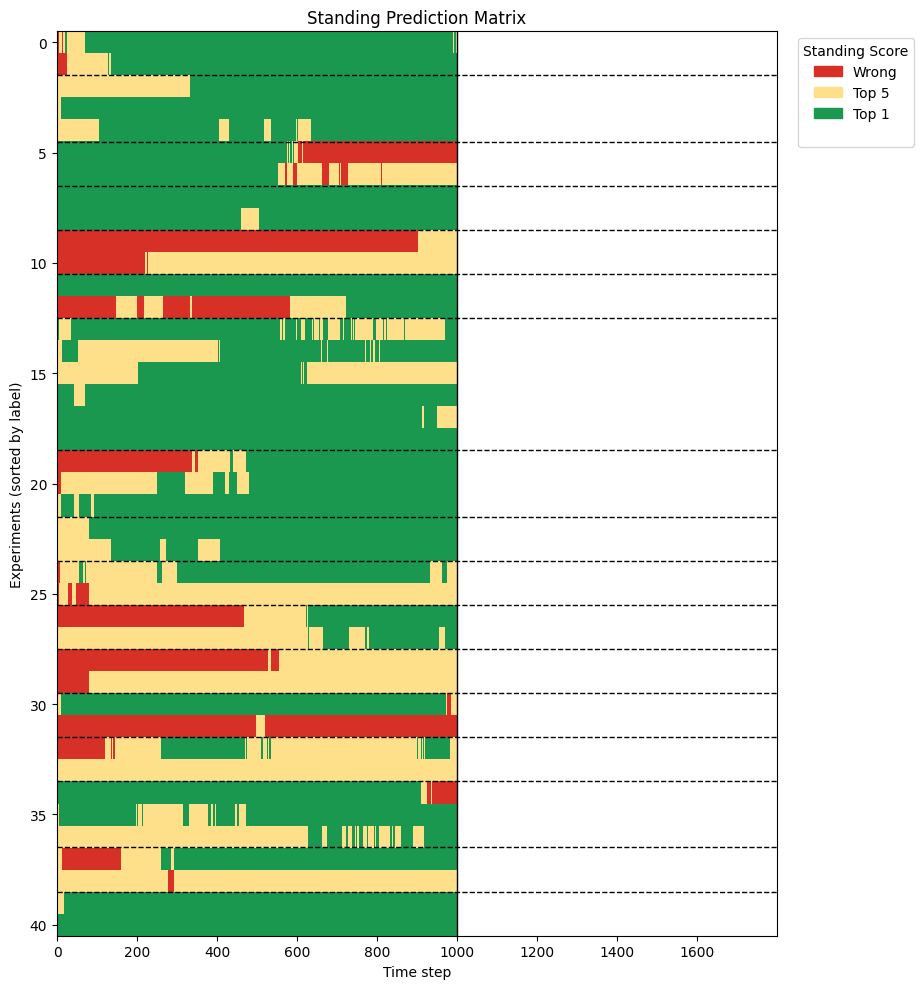

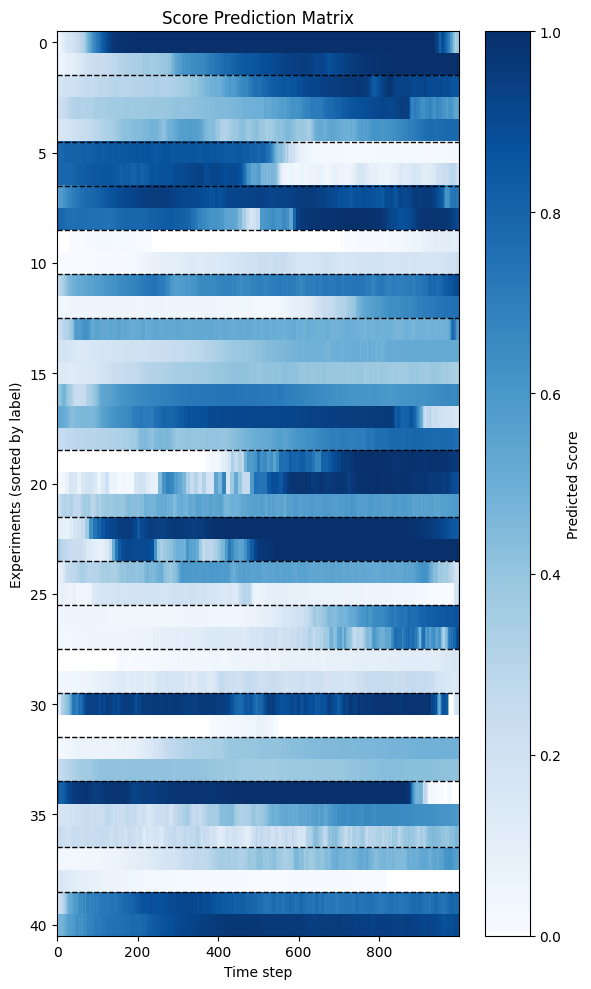

In [6]:
plot_prediction_matrix_stretched(pm_standing, index_to_exp_standing, df_test, order="label", cmap_color="Greens", title="Standing Prediction Matrix", mode="standing", stretch=1000, figsize=(9.35, 10), right_pad=800)
plot_prediction_matrix_stretched(pm_score, index_to_exp_score, df_test, order="label", cmap_color="Blues", title="Score Prediction Matrix", mode="score", stretch=1000, figsize=(6, 10))

### GRU RNN

In [5]:
model_path = os.path.join(model_dir, "RNN_GRU_h64_23052025_1754.ckpt")
pm_standing, index_to_exp_standing = build_prediction_matrix(model_path, RNNClassifier, test_dataset, label_encoder, mode="standing", device=device)
pm_score, index_to_exp_score = build_prediction_matrix(model_path, RNNClassifier, test_dataset, label_encoder, mode="score", device=device)

Predicting (score): 100%|██████████| 41/41 [00:00<00:00, 47.14it/s]


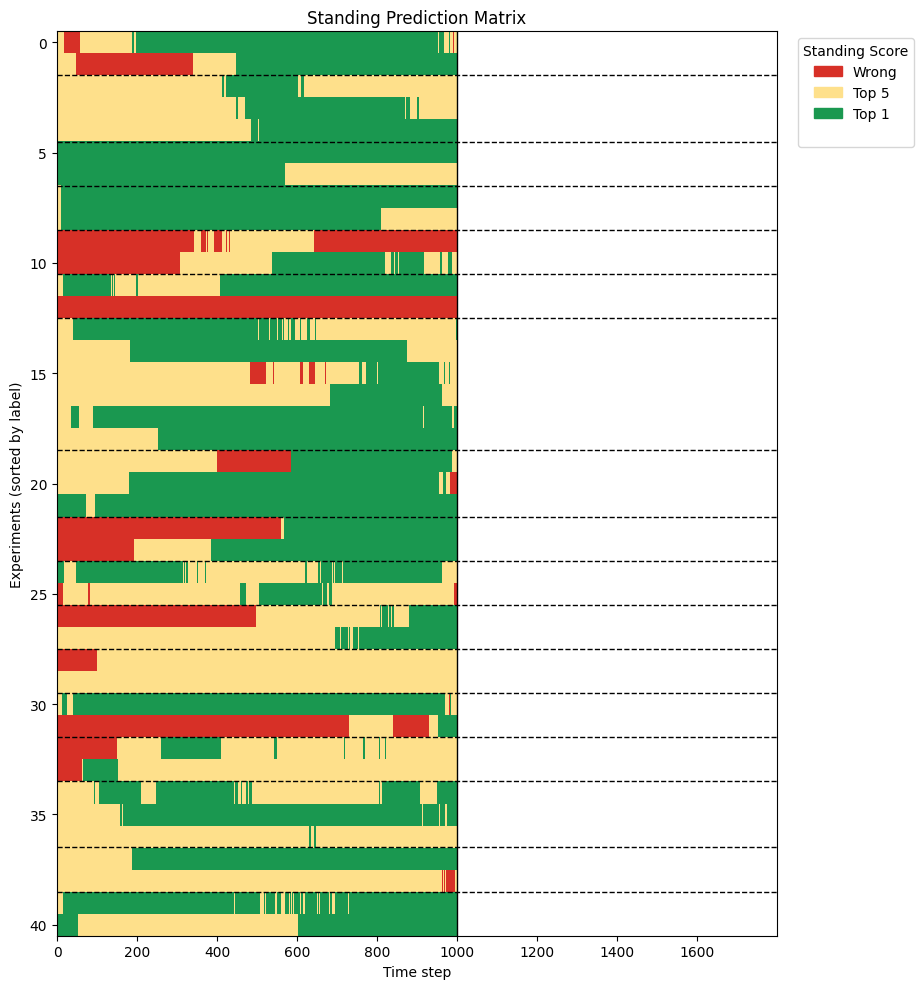

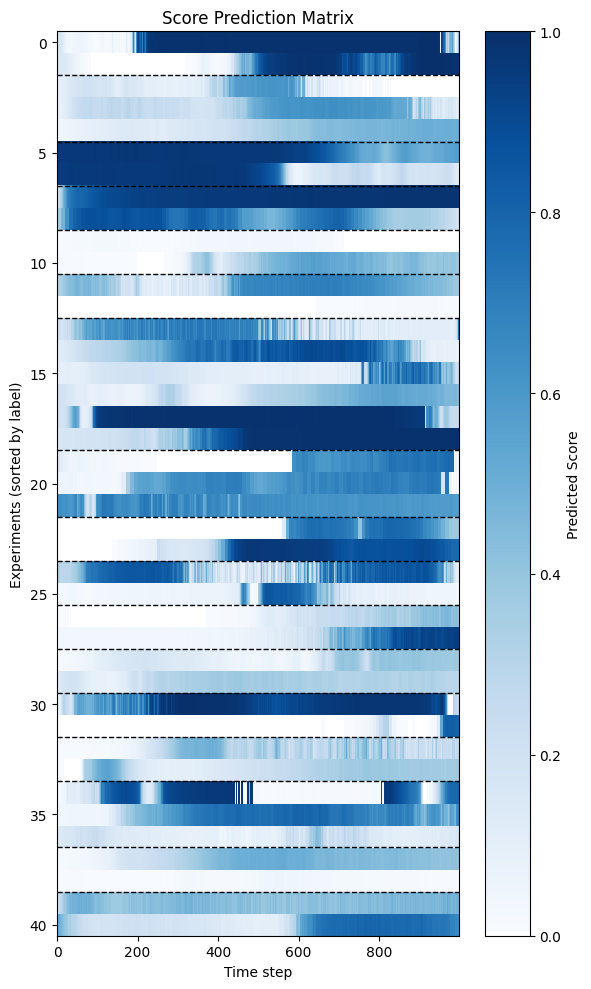

In [6]:
plot_prediction_matrix_stretched(pm_standing, index_to_exp_standing, df_test, order="label", cmap_color="Greens", title="Standing Prediction Matrix", mode="standing", stretch=1000, figsize=(9.35, 10), right_pad=800)
plot_prediction_matrix_stretched(pm_score, index_to_exp_score, df_test, order="label", cmap_color="Blues", title="Score Prediction Matrix", mode="score", stretch=1000, figsize=(6, 10))